# EOIR Asylum Decision Rates by Nationality
**Data Source:** [US Census](https://data.census.gov/cedsci/) <br>
**Download the Output:** [here](../data/extracted_data/doj)


## Overview 

DOJ-EOIR has published [data](https://www.justice.gov/eoir/page/file/1107366/download) on asylum decision rates by nationality since around 2019 as part of their switch from releasing annual statistical yearbooks to releasing regularly updated individual data sets (“workload and adjudication statistics”).

Every time they update this data they overwrite the previous year’s data, but we can access older versions of this PDF by using the [Wayback Machine](https://web.archive.org/web/*/https://www.justice.gov/eoir/page/file/1107366/download). In this notebook we will access the current PDF, older PDFs through the Wayback Machine and then extract that data to a single table. 

## Technical Approach

We will use Python to download the current PDF from EOIR, then download all archived PDFs from the Wayback Machine using a Python library called `waybackpy`, and then use code extract data from the PDFs and create a single dataset. 

 
## Skills Learned 
* How to download PDFs programmatically
* How to use code to access the Wayback Machine and download archived PDFs
* How to extract structured data from PDFs

## The Code

In [1]:
import os
import pprint
import sys
import time
from collections import Counter
from datetime import timedelta
from pathlib import Path

import numpy as np
import pandas as pd
import requests
import waybackpy

from PyPDF2 import PdfFileReader
from tabula.io import read_pdf

sys.path.append("../src")
pp = pprint.PrettyPrinter(indent=4)

from utils import are_files_identical

## 1. Download PDFs From Wayback Machine

**Functions**

In [2]:
def download_pdf(url, name, output_directory):
    """
    Function to download a single pdf file from a provided link.

    Parameters:
      url: URL of the file you want to download
      name: Label you want to apply to the file

      output_folder: Folder path to savae file

    Returns:
      Saves the file to the output directory, function itself returns nothing.

    Example:
      download_pdf(
        'https://www.justice.gov/eoir/page/file/1107366/download',
        'eoir_data',
        './'
      )
    """
    output_folder = Path(output_directory)
    response = requests.get(url)
    if response.status_code == 200:
        # Write content in pdf file
        outpath = output_directory / f"{name}.pdf"
        pdf = open(str(outpath), "wb")
        pdf.write(response.content)
        pdf.close()
        print("File ", f"{name}.pdf", " downloaded")
    else:
        print("File ", f"{name}.pdf", " not found.")

### Using a Wayback Machine Python Library to Get Wayback Machine URLs

We pick the url of a file / page we are insterested in, here it is [EOIR Adjudication Stats](https://www.justice.gov/eoir/page/file/1107366/download)

We also set up something called a user agent. A user agent is a grouping of information you pass to a website that suggests you are an actual person, vs. a machine (python code), using a web browser to access that website. 

Some websites block automated access so you need to provide this info.

We then pass the url and the user agent info to the waybackpy library and create an instance of the waybackpy tool for accessing the EOIR data.

In [3]:
url = "https://www.justice.gov/eoir/page/file/1107366/download"
user_agent = "Mozilla/5.0 (Windows NT 5.1; rv:40.0) Gecko/20100101 Firefox/40.0"
wayback = waybackpy.Url(url, user_agent)

The waybackpy package allows us to find the oldest date and newest date a url was archived. We can also search for the date that is nearest a date that we provide. 

So what we will do is:
1. get the oldest date
2. then search every 90 days from the oldest date till we reach the newest date for the archive date 
3. save each of those dates and their corresponding wayback urls 
4. make sure we only get unique wayback urls (note this does not guarantee that the data archived is unique) 
5. then download each of the pdf files associated with those wayback archive urls. 

In [4]:
# Python Dictionary to store the Wayback urls
wb_archive_urls = {}

# Get the oldest archive date and URL
oldest = wayback.oldest()
oldest_date = oldest.timestamp
print("Oldest Archive Date", oldest_date)
wb_archive_urls[oldest_date] = oldest.archive_url

# Get the newest archive date and URL
newest = wayback.newest()
newest_date = newest.timestamp
print("Newest Archive Date", newest_date)
wb_archive_urls[newest_date] = newest.archive_url

Oldest Archive Date 2019-03-06 01:21:00
Newest Archive Date 2021-09-28 21:11:24


Now we will do the following:
* Take the oldest date and set a variable called `search_date` to it
* then keep adding 90 days to the search date and see if the wayback
* machine has a new archive date near that search date
* stop when we reach the newest date

**Note**: Sometimes the Wayback machine doesn't provide a response, or says there is no archive. If you get an error give it a couple attempts

In [5]:
search_date = oldest_date
retrieved_dates = [oldest_date, newest_date]

while search_date < newest_date:
    search_date += timedelta(days=90)
    check_for_next = wayback.near(year=search_date.year, month=search_date.month)
    if check_for_next.timestamp in retrieved_dates:
        continue
    else:
        retrieved_dates.append(check_for_next.timestamp)
        wb_archive_urls[check_for_next.timestamp] = check_for_next.archive_url

pp.pprint(sorted(retrieved_dates))

[   datetime.datetime(2019, 3, 6, 1, 21),
    datetime.datetime(2019, 10, 3, 1, 7, 56),
    datetime.datetime(2019, 11, 13, 2, 8, 38),
    datetime.datetime(2020, 2, 1, 3, 59, 31),
    datetime.datetime(2020, 5, 19, 1, 19, 51),
    datetime.datetime(2020, 8, 1, 19, 34, 30),
    datetime.datetime(2020, 9, 28, 23, 53, 59),
    datetime.datetime(2021, 1, 19, 23, 28, 15),
    datetime.datetime(2021, 5, 17, 22, 57, 49),
    datetime.datetime(2021, 9, 28, 21, 11, 24)]


The dates above are year, month, day, hour, minute. So we can see that we have grabbed urls for dates ranging from 2019-03-06 - 2021-09-28 . This date range will shift depending on when the code is run.

Below we print our dictionary of wayback urls, where the keys are the dates. 

In [6]:
pp.pprint(wb_archive_urls)

{   datetime.datetime(2019, 3, 6, 1, 21): 'https://web.archive.org/web/20190306012100/https://www.justice.gov/eoir/page/file/1107366/download',
    datetime.datetime(2019, 10, 3, 1, 7, 56): 'https://web.archive.org/web/20191003010756/https://www.justice.gov/eoir/page/file/1107366/download',
    datetime.datetime(2019, 11, 13, 2, 8, 38): 'https://web.archive.org/web/20191113020838/https://www.justice.gov/eoir/page/file/1107366/download',
    datetime.datetime(2020, 2, 1, 3, 59, 31): 'https://web.archive.org/web/20200201035931/https://www.justice.gov/eoir/page/file/1107366/download',
    datetime.datetime(2020, 5, 19, 1, 19, 51): 'https://web.archive.org/web/20200519011951/https://www.justice.gov/eoir/page/file/1107366/download',
    datetime.datetime(2020, 8, 1, 19, 34, 30): 'https://web.archive.org/web/20200801193430/https://www.justice.gov/eoir/page/file/1107366/download',
    datetime.datetime(2020, 9, 28, 23, 53, 59): 'https://web.archive.org/web/20200928235359/https://www.justice.g

### Now Download the PDFs from the Wayback Machine

In [8]:
# We will save the pdfs in the export directory below
export_directory = Path("../data/raw_source_files/justice.gov/")

for link in wb_archive_urls:
    wb_url = wb_archive_urls[link]
    download_pdf(wb_url, f"eoir_adjudication_stats_{str(link)}", export_directory)

File  eoir_adjudication_stats_2019-03-06 01:21:00.pdf  downloaded
File  eoir_adjudication_stats_2021-09-28 21:11:24.pdf  downloaded
File  eoir_adjudication_stats_2019-10-03 01:07:56.pdf  downloaded
File  eoir_adjudication_stats_2019-11-13 02:08:38.pdf  downloaded
File  eoir_adjudication_stats_2020-02-01 03:59:31.pdf  downloaded
File  eoir_adjudication_stats_2020-05-19 01:19:51.pdf  downloaded
File  eoir_adjudication_stats_2020-08-01 19:34:30.pdf  downloaded
File  eoir_adjudication_stats_2020-09-28 23:53:59.pdf  downloaded
File  eoir_adjudication_stats_2021-01-19 23:28:15.pdf  downloaded
File  eoir_adjudication_stats_2021-05-17 22:57:49.pdf  downloaded


### Now Download the most recent PDF from DOJ

We always want to grab the current DOJ PDF and make sure we don't already have it. Realistically once we have grabbed all the Wayback PDFs, in the future we just need to see if the DOJ has updated their file and then we want to add it to our directory of files. 

**Download the file and tag it with the current date and time**

In [9]:
current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
new_file_label = f"eoir_adjudication_stats_{current_time}"
new_file_path = export_directory / f"{new_file_label}.pdf"
download_pdf(url, new_file_label, export_directory)
print("New Download: ", export_directory / new_file_label)

File  eoir_adjudication_stats_2021-12-03 15:34:17.pdf  downloaded
New Download:  ../data/raw_source_files/justice.gov/eoir_adjudication_stats_2021-12-03 15:34:17


**Now we will check if the file is new/different**
We will iterate over the `export_directory` and check to see if the files are identical. We are using a function that checks the hash or bytes of the file. If the file is new we will keep it. If it is identical to another file we already have we will delete it. 

In [10]:
is_new_file = True
for file in export_directory.iterdir():
    if file != new_file_path:
        if are_files_identical(file, new_file_path):
            print("DOJ file is not updated - will delete")
            is_new_file = False
            break

if is_new_file:
    print("DOJ file is updated")
else:
    os.remove(new_file_path)

DOJ file is not updated - will delete


Now, we can list files in a directory with the ls command - below we can see that we have successfully downloaded all of the PDFs

In [11]:
ls ../data/raw_source_files/justice.gov/

eoir_adjudication_stats_2019-03-06 01:21:00.pdf
eoir_adjudication_stats_2019-10-03 01:07:56.pdf
eoir_adjudication_stats_2019-11-13 02:08:38.pdf
eoir_adjudication_stats_2020-01-14 02:26:25.pdf
eoir_adjudication_stats_2020-02-01 03:59:31.pdf
eoir_adjudication_stats_2020-05-19 01:19:51.pdf
eoir_adjudication_stats_2020-08-01 19:34:30.pdf
eoir_adjudication_stats_2020-09-28 23:53:59.pdf
eoir_adjudication_stats_2020-12-20 19:26:12.pdf
eoir_adjudication_stats_2021-01-19 23:28:15.pdf
eoir_adjudication_stats_2021-03-02 13:53:24.pdf
eoir_adjudication_stats_2021-05-17 22:57:49.pdf
eoir_adjudication_stats_2021-09-28 21:11:24.pdf
eoir_adjudication_stats_2021-12-01 15:43:44.pdf


**Note**: We still don't know if all of these PDFs actually have unique information, most of these PDFs  are just when Wayback archived them. Therefore we want to check if the PDF is unique. The only place in the PDF where it indicates what term this data covers (specifically what Fiscal Year and what date the data was generated on) is the in the #1 Footnote.

We have written some additional code below that opens the PDF, searches for this footnote and parses out the Fiscal Year and Generated on Date. 

In [12]:
def get_fy_and_generated_on(pdf_path):
    """
    Function to extract the Fiscal Year of the data, and the date the data
    was generated. This information is stored in footnotes in the pdf. We use the
    PdfFileReader to extract the plain text and then search for the fiscal year
    and generated on date. Iterates through all pages and then picks the most
    common result for fiscal year and generated on date.

    Parameters:
        pdf_path: path to pdf

    Returns:
        List of (fiscal_year, generated_on_date)
    """
    date_re = "(Jan(uary)?|Feb(ruary)?|Mar(ch)?|Apr(il)?|May|Jun(e)?|Jul(y)?|Aug(ust)?|Sep(tember)?|Oct(ober)?|Nov(ember)?|Dec(ember)?)\s+\d{1,2},\s+\d{4}"
    pdf = PdfFileReader(str(pdf_path))
    fiscal_year_options = []
    generated_on_options = []
    for i in range(pdf.getNumPages()):
        try:
            pdf_text = pdf.getPage(i).extractText()
            fiscal_year_idx = pdf_text.lower().find("fiscal year")
            fiscal_year = (
                pdf_text[fiscal_year_idx:].split()[2:3][0].strip().replace(".", "")
            )
            generated_date = [
                i.group() for i in re.finditer(date_re, pdf_text.replace("\n", ""))
            ][-1].strip()
            fiscal_year_options.append(fiscal_year)
            generated_on_options.append(generated_date)
        except Exception as e:
            print(e)
            # We are trying multiple pages so if one errors out we will ignore it
            continue

    fy_most_common = Counter(fiscal_year_options).most_common()
    go_most_common = Counter(generated_on_options).most_common()
    return [fy_most_common[0][0], go_most_common[0][0]]

We can do this on one PDF first, specifically the `eoir_adjudication_stats_2019-03-06 01:21:00.pdf` file. If you examine this file you will see the footnotes at the bottm (see image below). When you run the following code cell you should see 2018, and October 24, 2018 printed out. 

![img]("../misc/images/doj_footnote_example.png")

<img src="../misc/images/doj_footnote_example_img.png"/>

In [14]:
get_fy_and_generated_on(
    "../data/raw_source_files/justice.gov/eoir_adjudication_stats_2019-03-06 01:21:00.pdf"
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

['2018', 'October 24, 2018']

The function returns the fiscal year and date generated in a list. We can now iterate over all of our files and then build a dataframe to see all of the files, their fiscal years and data date generated. 

In [15]:
# Iterate over all files in our folder
file_info = []
for p in Path("../data/raw_source_files/justice.gov/").iterdir():
    fiscal_year, generated_on = get_fy_and_generated_on(p)
    file_info.append([str(p), fiscal_year, generated_on])

file_info_df = pd.DataFrame(
    file_info, columns=["file", "fiscal_year", "generated_on"]
).sort_values("file")
file_info_df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,file,fiscal_year,generated_on
9,../data/raw_source_files/justice.gov/eoir_adju...,2018,"October 24, 2018"
7,../data/raw_source_files/justice.gov/eoir_adju...,2018,"October 24, 2018"
6,../data/raw_source_files/justice.gov/eoir_adju...,2019,"October 23, 2019"
12,../data/raw_source_files/justice.gov/eoir_adju...,2019,"October 23, 2019"
5,../data/raw_source_files/justice.gov/eoir_adju...,2019,"October 23, 2019"
4,../data/raw_source_files/justice.gov/eoir_adju...,2019,"October 23, 2019"
3,../data/raw_source_files/justice.gov/eoir_adju...,2020,"July 14, 2020"
2,../data/raw_source_files/justice.gov/eoir_adju...,2020,"July 14, 2020"
11,../data/raw_source_files/justice.gov/eoir_adju...,2020,"July 14, 2020"
1,../data/raw_source_files/justice.gov/eoir_adju...,2021,"January 7, 2020"


Above we see that some of the files have duplicated information. We want to keep only files with unique information.

In [16]:
file_info_df = file_info_df.drop_duplicates(["fiscal_year", "generated_on"])
file_info_df

,file,fiscal_year,generated_on
9,../data/raw_source_files/justice.gov/eoir_adju...,2018,"October 24, 2018"
6,../data/raw_source_files/justice.gov/eoir_adju...,2019,"October 23, 2019"
3,../data/raw_source_files/justice.gov/eoir_adju...,2020,"July 14, 2020"
1,../data/raw_source_files/justice.gov/eoir_adju...,2021,"January 7, 2020"
0,../data/raw_source_files/justice.gov/eoir_adju...,2021,"April 19, 2021"
8,../data/raw_source_files/justice.gov/eoir_adju...,2021,"July 8, 2021"
13,../data/raw_source_files/justice.gov/eoir_adju...,2021,"October 19, 2021"


Now above we can see our unique datasets.

## 2. Extracting Structured Data from the PDFs 

### First Let's Try 1 PDF

**First let's extract one page to see if the tabula library is successful**

In [17]:
extract_test = read_pdf(
    export_directory / "eoir_adjudication_stats_2019-03-06 01:21:00.pdf",
    pages=1,
    lattice=True,
    pandas_options={"header": None},  # none because some have headers and some dont
)[0]

Below we see the single extracted page - by comparing to page 1 of that actual pdf we can see that overall the results look great. 


In [18]:
extract_test.head(20)

,0,1,2,3,4,5,6,7,8,9
0,Admin\rDenialAdmin\rNationalityGrants2\rGrant ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Nationality,Grants2,Grant Rate,Denials,Denial\rRate,Other3,Other Rate,Admin\rClosure4,Admin\rClosure\rRate,Total
2,AFGHANISTAN,28,*,19,*,21,*,*,*,*
3,ALBANIA,181,62.41%,55,18.97%,49,16.90%,5,1.72%,290
4,ALGERIA,*,*,*,*,*,*,*,*,*
5,ANGOLA,19,*,29,*,10,*,*,*,*
6,ANTIGUA AND\rBARBUDA,*,*,*,*,*,*,*,*,*
7,ARGENTINA,*,*,8,*,16,*,*,*,*
8,ARMENIA,60,*,39,*,43,*,*,*,*
9,AUSTRALIA,*,*,*,*,*,*,*,*,*



The only issue is that the headers are pretty messed up. If we check a couple of other pages (try putting in 2,3,4) for the `pages=1` value. We see this is a consistent issue and actually we can just drop the first 2 rows.

So we will write that into our `get_table_data` function.

In [19]:
def get_table_data(path):
    """
    Parameters:
      path: path to specific PDF file to extract data from

    Returns:
      Pandas dataframe of structured (tabular) data extracted from the PDF
      path provided.

    Example:
      get_table_data( 'eoir_adjudication_stats_2019-03-06 01:21:00.pdf' )

    """
    # Read the pdf to get basic info on it
    pdf = PdfFileReader(path)

    # Data Holders
    full_table = pd.DataFrame()  # Will hold the combined data

    # Processing PDF - we start with the first page (start) and go to the last page (stop)
    start = 1
    stop = pdf.getNumPages() + 1
    for i in range(start, stop):
        # Extract data from the specific PDF page using Tabula
        df = read_pdf(
            path,
            pages=f"{i}",
            lattice=True,
            pandas_options={
                "header": None
            },  # none because some have headers and some dont
        )[0]
        if len(df.columns) == 10:
            df.columns = [
                "nationality",
                "grants",
                "grant rate",
                "denials",
                "denial rate",
                "other",
                "other rate",
                "admin closure",
                "admin closure rate",
                "total",
            ]
        elif len(df.columns) == 8:
            df.columns = [
                "nationality",
                "grants",
                "grant rate",
                "denials",
                "denial rate",
                "other",
                "other rate",
                "total",
            ]
        else:
            raise AssertionError(
                "Something is wrong with column lengths check the pdf file manually"
            )
        # Here we drop the first N rows, the weird headers.
        df = df.loc[
            df[df["nationality"].str.lower().str.contains("nationality")].index.max()
            + 1 :,
            :,
        ]

        df = df[~df["nationality"].str.lower().str.contains("asylum rates for fiscal")]
        # Append this page of data to the full table
        full_table = full_table.append(df)

    return full_table

Let's define the columns that are in the source table

In [20]:
pdf_cols = [
    "nationality",
    "grants",
    "grant rate",
    "denials",
    "denial rate",
    "other",
    "other rate",
    "admin closure",
    "admin closure rate",
    "total",
]

Now grab the full pdf

In [21]:
test = get_table_data(
    str(export_directory / "eoir_adjudication_stats_2019-03-06 01:21:00.pdf")
)

In [22]:
test.head()

,nationality,grants,grant rate,denials,denial rate,other,other rate,admin closure,admin closure rate,total
2,AFGHANISTAN,28,*,19,*,21,*,*,*,*
3,ALBANIA,181,62.41%,55,18.97%,49,16.90%,5,1.72%,290
4,ALGERIA,*,*,*,*,*,*,*,*,*
5,ANGOLA,19,*,29,*,10,*,*,*,*
6,ANTIGUA AND\rBARBUDA,*,*,*,*,*,*,*,*,*


Looks pretty great, only issue is that we have asterisks in the data, and I bet we have some "," separators in the dataset as well. This is a problem because it means we can't treat those columns as having real numbers in them, making it impossible to aggregate. 

**[OPTIONAL]  Cleaning the data** 

This is optional because you could likley do this in excel instead

In [23]:
# Clean the asterisks - replace all of them with NULL or nan(not a number)
test = test.replace("*", np.nan)

# Iterate over the columns
# convert the value to type string, then replace any "," with "",
# and convert the new value to type float.
numerics = ["grants", "denials", "other", "admin closure", "total"]
for col in numerics:
    test[col] = test[col].astype(str).str.replace(",", "").astype(float)

In [24]:
test.head()

,nationality,grants,grant rate,denials,denial rate,other,other rate,admin closure,admin closure rate,total
2,AFGHANISTAN,28.0,NaN,19.0,NaN,21.0,NaN,NaN,NaN,NaN
3,ALBANIA,181.0,62.41%,55.0,18.97%,49.0,16.90%,5.0,1.72%,290.0
4,ALGERIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ANGOLA,19.0,NaN,29.0,NaN,10.0,NaN,NaN,NaN,NaN
6,ANTIGUA AND\rBARBUDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Second Let's Get All PDFs

Earlier we identifed the unique pdfs to grab and saved some info about them in the `file_info_df` dictionary

In [25]:
file_info_df

,file,fiscal_year,generated_on
9,../data/raw_source_files/justice.gov/eoir_adju...,2018,"October 24, 2018"
6,../data/raw_source_files/justice.gov/eoir_adju...,2019,"October 23, 2019"
3,../data/raw_source_files/justice.gov/eoir_adju...,2020,"July 14, 2020"
1,../data/raw_source_files/justice.gov/eoir_adju...,2021,"January 7, 2020"
0,../data/raw_source_files/justice.gov/eoir_adju...,2021,"April 19, 2021"
8,../data/raw_source_files/justice.gov/eoir_adju...,2021,"July 8, 2021"
13,../data/raw_source_files/justice.gov/eoir_adju...,2021,"October 19, 2021"


**Now we will iterate over the rows, and get the data from each file**

In [26]:
tables = []
for idx, row in file_info_df.iterrows():
    # Assign information from the row of the data frame to some variables
    pdf_path = row["file"]
    fiscal_year = row["fiscal_year"]
    generated_on = row["generated_on"]

    # Get the table data for this pdf path
    table = get_table_data(pdf_path)

    # Assign our extra variables
    table["fiscal_year"] = fiscal_year
    table["generated_my"] = generated_on
    table["pdf_file"] = pdf_path

    # Append the processed table to our tables list
    tables.append(table)

**Create a single dataframe from all our tables**

In [27]:
all_data_df = pd.DataFrame()
for table in tables:
    all_data_df = all_data_df.append(table)
all_data_df = all_data_df.reset_index(drop=True)
all_data_df

,nationality,grants,grant rate,denials,denial rate,other,other rate,admin closure,admin closure rate,total,fiscal_year,generated_my,pdf_file
0,AFGHANISTAN,28,*,19,*,21,*,*,*,*,2018,"October 24, 2018",../data/raw_source_files/justice.gov/eoir_adju...
1,ALBANIA,181,62.41%,55,18.97%,49,16.90%,5,1.72%,290,2018,"October 24, 2018",../data/raw_source_files/justice.gov/eoir_adju...
2,ALGERIA,*,*,*,*,*,*,*,*,*,2018,"October 24, 2018",../data/raw_source_files/justice.gov/eoir_adju...
3,ANGOLA,19,*,29,*,10,*,*,*,*,2018,"October 24, 2018",../data/raw_source_files/justice.gov/eoir_adju...
4,ANTIGUA AND\rBARBUDA,*,*,*,*,*,*,*,*,*,2018,"October 24, 2018",../data/raw_source_files/justice.gov/eoir_adju...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,VENEZUELA,472,46%,199,19%,360,35%,NaN,NaN,"1,031",2021,"October 19, 2021",../data/raw_source_files/justice.gov/eoir_adju...
1011,VIETNAM,45,59%,17,22%,14,18%,NaN,NaN,76,2021,"October 19, 2021",../data/raw_source_files/justice.gov/eoir_adju...
1012,YEMEN,13,30%,13,30%,18,41%,NaN,NaN,44,2021,"October 19, 2021",../data/raw_source_files/justice.gov/eoir_adju...
1013,ZAMBIA,*,*,*,*,*,*,NaN,NaN,*,2021,"October 19, 2021",../data/raw_source_files/justice.gov/eoir_adju...


**Do some clean up**

In [28]:
# Clean the asterisks - replace all of them with NULL or nan(not a number)
all_data_df = all_data_df.replace("*", np.nan)

# Convert the numeric columns to a float - iterate over the columns,
# convert the value to type string, then replace any "," with "",
# and convert the new value to type float.
numerics = ["grants", "denials", "other", "admin closure", "total"]
for col in numerics:
    all_data_df[col] = all_data_df[col].astype(str).str.replace(",", "").astype(float)

Note: We did not clean up the `rate` columsn in the dataframe, they still have `%` stored in their values which makes them a string. See the appendix for how we can easily clean up those columns. 

In [29]:
all_data_df.generated_my = pd.to_datetime(all_data_df.generated_my)

all_data_df

,nationality,grants,grant rate,denials,denial rate,other,other rate,admin closure,admin closure rate,total,fiscal_year,generated_my,pdf_file
0,AFGHANISTAN,28.0,NaN,19.0,NaN,21.0,NaN,NaN,NaN,NaN,2018,2018-10-24,../data/raw_source_files/justice.gov/eoir_adju...
1,ALBANIA,181.0,62.41%,55.0,18.97%,49.0,16.90%,5.0,1.72%,290.0,2018,2018-10-24,../data/raw_source_files/justice.gov/eoir_adju...
2,ALGERIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,2018-10-24,../data/raw_source_files/justice.gov/eoir_adju...
3,ANGOLA,19.0,NaN,29.0,NaN,10.0,NaN,NaN,NaN,NaN,2018,2018-10-24,../data/raw_source_files/justice.gov/eoir_adju...
4,ANTIGUA AND\rBARBUDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,2018-10-24,../data/raw_source_files/justice.gov/eoir_adju...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,VENEZUELA,472.0,46%,199.0,19%,360.0,35%,NaN,NaN,1031.0,2021,2021-10-19,../data/raw_source_files/justice.gov/eoir_adju...
1011,VIETNAM,45.0,59%,17.0,22%,14.0,18%,NaN,NaN,76.0,2021,2021-10-19,../data/raw_source_files/justice.gov/eoir_adju...
1012,YEMEN,13.0,30%,13.0,30%,18.0,41%,NaN,NaN,44.0,2021,2021-10-19,../data/raw_source_files/justice.gov/eoir_adju...
1013,ZAMBIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021,2021-10-19,../data/raw_source_files/justice.gov/eoir_adju...


**Now export the file to our `extracted_date/doj` directory**

In [30]:
todays_date = time.strftime("%Y_%m_%d")
all_data_df.to_csv(
    f"../data/extracted_data/doj/doj_eoir_asylym_decisions_{todays_date}.csv"
)

-------------

# Appendix


## Visualizations

### A quick chart just for reference

<AxesSubplot:xlabel='generated_my'>

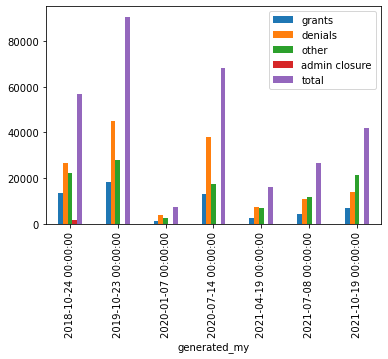

In [31]:
all_data_df.groupby(["generated_my"])[numerics].sum().sort_index().plot(kind="bar")

## Additional Data Cleaning


### Converting the `rate` columns to numeric

* First isolate the rate columns into a list
* Then iterate over those columns
    * Convert to string, replace % and * and then make a number and divide by zero. 

In [32]:
# Note the space in front of ` rate` keeps is from also grabbing `generated_on`
rate_columns = [i for i in all_data_df.columns if " rate" in i]
for col in rate_columns:
    # Make sure the column is of type string
    all_data_df[col] = all_data_df[col].astype(str)
    # replace '%' and '*' with ""
    all_data_df[col] = (
        all_data_df[col]
        .str.replace("%", "", regex=False)
        .str.replace("*", "", regex=False)
    )
    # then convert to a float number and divide by 100
    all_data_df[col] = all_data_df[col].astype(float) / 100

In [33]:
all_data_df

,nationality,grants,grant rate,denials,denial rate,other,other rate,admin closure,admin closure rate,total,fiscal_year,generated_my,pdf_file
0,AFGHANISTAN,28.0,NaN,19.0,NaN,21.0,NaN,NaN,NaN,NaN,2018,2018-10-24,../data/raw_source_files/justice.gov/eoir_adju...
1,ALBANIA,181.0,0.6241,55.0,0.1897,49.0,0.169,5.0,0.0172,290.0,2018,2018-10-24,../data/raw_source_files/justice.gov/eoir_adju...
2,ALGERIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,2018-10-24,../data/raw_source_files/justice.gov/eoir_adju...
3,ANGOLA,19.0,NaN,29.0,NaN,10.0,NaN,NaN,NaN,NaN,2018,2018-10-24,../data/raw_source_files/justice.gov/eoir_adju...
4,ANTIGUA AND\rBARBUDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,2018-10-24,../data/raw_source_files/justice.gov/eoir_adju...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,VENEZUELA,472.0,0.4600,199.0,0.1900,360.0,0.350,NaN,NaN,1031.0,2021,2021-10-19,../data/raw_source_files/justice.gov/eoir_adju...
1011,VIETNAM,45.0,0.5900,17.0,0.2200,14.0,0.180,NaN,NaN,76.0,2021,2021-10-19,../data/raw_source_files/justice.gov/eoir_adju...
1012,YEMEN,13.0,0.3000,13.0,0.3000,18.0,0.410,NaN,NaN,44.0,2021,2021-10-19,../data/raw_source_files/justice.gov/eoir_adju...
1013,ZAMBIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021,2021-10-19,../data/raw_source_files/justice.gov/eoir_adju...


# End